In [5]:
# My created .py files for modularization
import env
import os
import wrangle as w
# Ignore Warning
import warnings
warnings.filterwarnings("ignore")
# Array and Dataframes
import numpy as np
import pandas as pd
# Imputer
from sklearn.impute import SimpleImputer
# Evaluation: Visualization
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
# Evaluation: Statistical Analysis
from scipy import stats
# Modeling: Scaling
from sklearn.preprocessing import QuantileTransformer, MinMaxScaler, StandardScaler, RobustScaler
# Modeling
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier as knn
# Metrics
from sklearn.metrics import accuracy_score, precision_score, recall_score, classification_report, confusion_matrix, ConfusionMatrixDisplay

In [25]:
zillow = w.zillow()

File exists, pulling from system.


In [26]:
# Splitting data for modeling
train, validate, test = w.splitter(zillow,target='taxamount')


Dataframe: (2140235, 6) 100%
Train: (1369750, 6) | ~60%
Validate: (342438, 6) | ~20%
Test: (428047, 6) | ~20%


### 1. Apply the scalers we talked about in this lesson to your data and visualize the results for the unscaled and scaled distribution.

In [27]:
train_scaled = train.copy()

In [10]:
train.columns

,bedroomcnt,bathroomcnt,sq_feet,tax_value,yearbuilt,county
353297,4,2.0,1834,520117,1969,Orange
1185246,3,2.0,1694,378680,1949,LA
452922,4,3.0,2295,432768,1978,Ventura
163875,3,2.0,2182,393305,1969,LA
27042,4,2.0,2187,131101,1945,LA
...,...,...,...,...,...,...
1324400,5,3.0,2745,749000,1969,Orange
1379871,3,2.0,1782,261397,1954,LA
1679286,0,1.0,1240,186063,1925,LA
335945,4,1.0,1116,57994,1956,LA


In [29]:
# make, fit, use:
columns_to_scale = ['bedroomcnt', 'bathroomcnt','tax_value', 'sq_feet']
# make the object, put it into the variable scaler
scaler = MinMaxScaler()
# fit the object to my data:
train_scaled[columns_to_scale] = scaler.fit_transform(train[columns_to_scale])

Text(0, 0.5, 'Count')

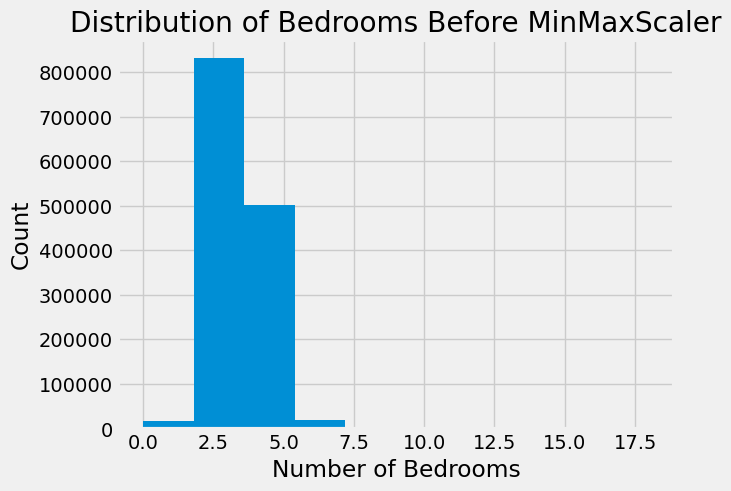

In [31]:
plt.hist(train.bedroomcnt)
plt.title('Distribution of Bedrooms Before MinMaxScaler')
plt.xlabel('Number of Bedrooms')
plt.ylabel('Count')

Text(0, 0.5, 'Count')

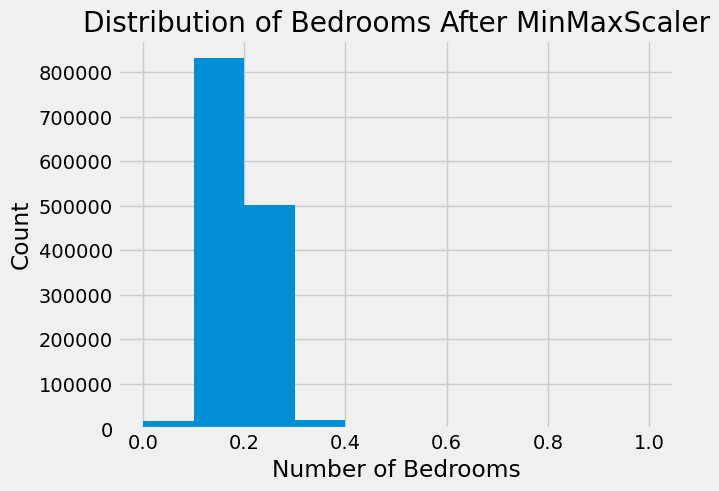

In [32]:
plt.hist(train_scaled.bedroomcnt)
plt.title('Distribution of Bedrooms After MinMaxScaler')
plt.xlabel('Number of Bedrooms')
plt.ylabel('Count')

In [12]:
# assigning x and y
x_train = train[['bedroomcnt','bathroomcnt','sq_feet']]
y_train = train['tax_value']

x_validate = validate[['bedroomcnt','bathroomcnt','sq_feet']]
y_validate = validate['tax_value']

x_test = test[['bedroomcnt','bathroomcnt','sq_feet']]
y_test = test['tax_value']

In [33]:
def visualize_scaler(scaler, df, columns_to_scale, bins=10):
    fig, axs = plt.subplots(len(columns_to_scale), 2, figsize=(16,9))
    df_scaled = df.copy()
    df_scaled[columns_to_scale] = scaler.fit_transform(df[columns_to_scale])
    for (ax1, ax2), col in zip(axs, columns_to_scale):
        ax1.hist(df[col], bins=bins)
        ax1.set(title=f'{col} before scaling', xlabel=col, ylabel='count')
        ax2.hist(df_scaled[col], bins=bins)
        ax2.set(title=f'{col} after scaling with {scaler.__class__.__name__}', xlabel=col, ylabel='count')
    plt.tight_layout()
#    return fig, axs

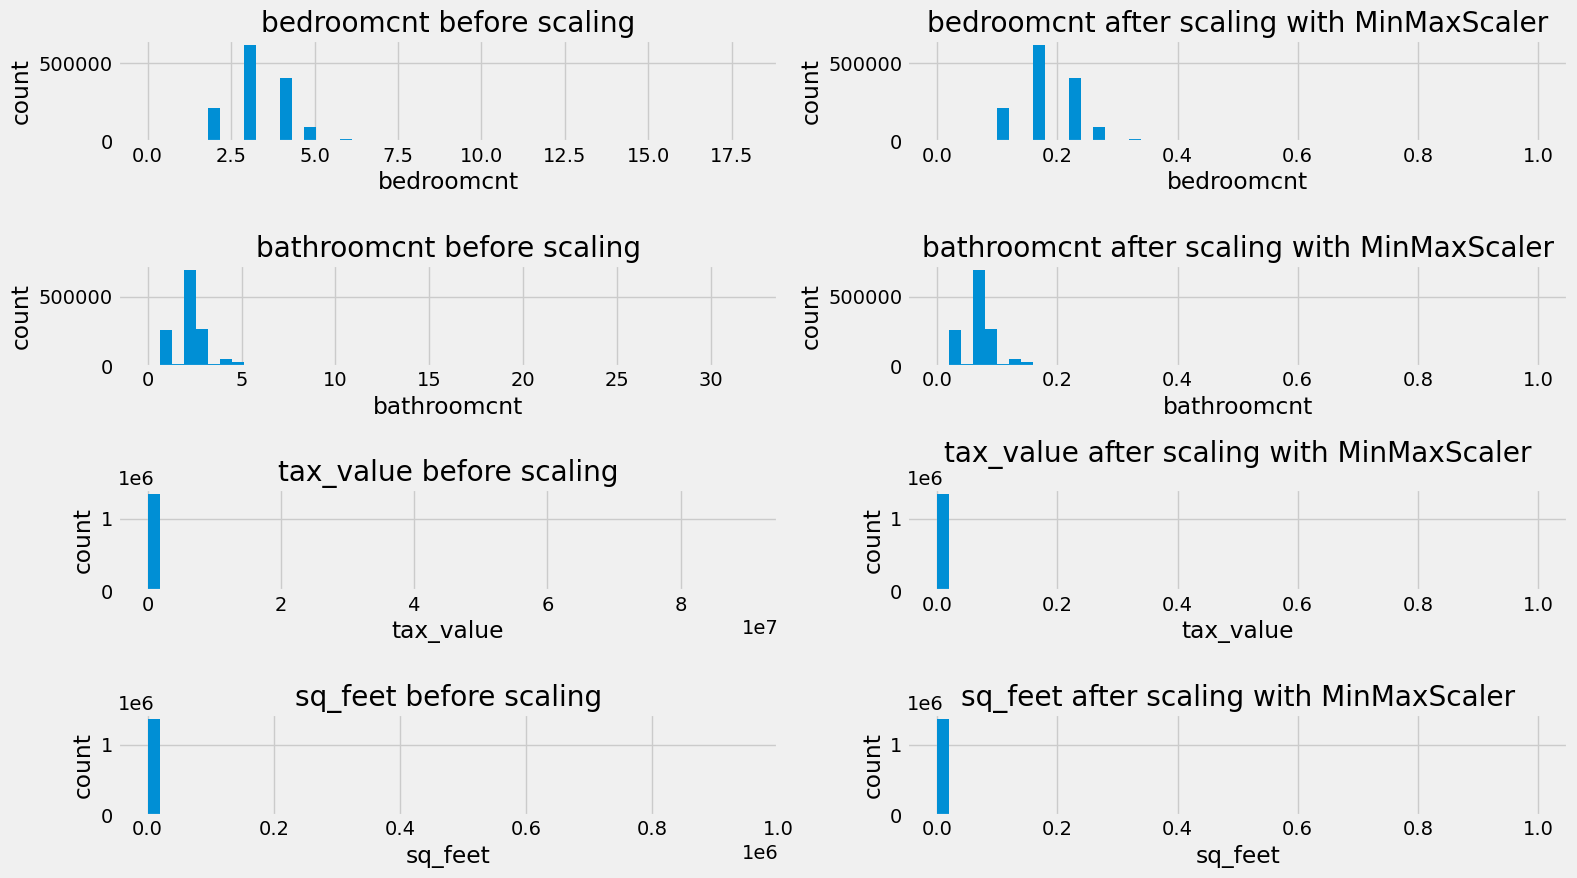

In [34]:
# MinMaxScaler Applied
visualize_scaler(scaler=MinMaxScaler(), 
                 df=train, 
                 columns_to_scale=columns_to_scale, 
                 bins=50)

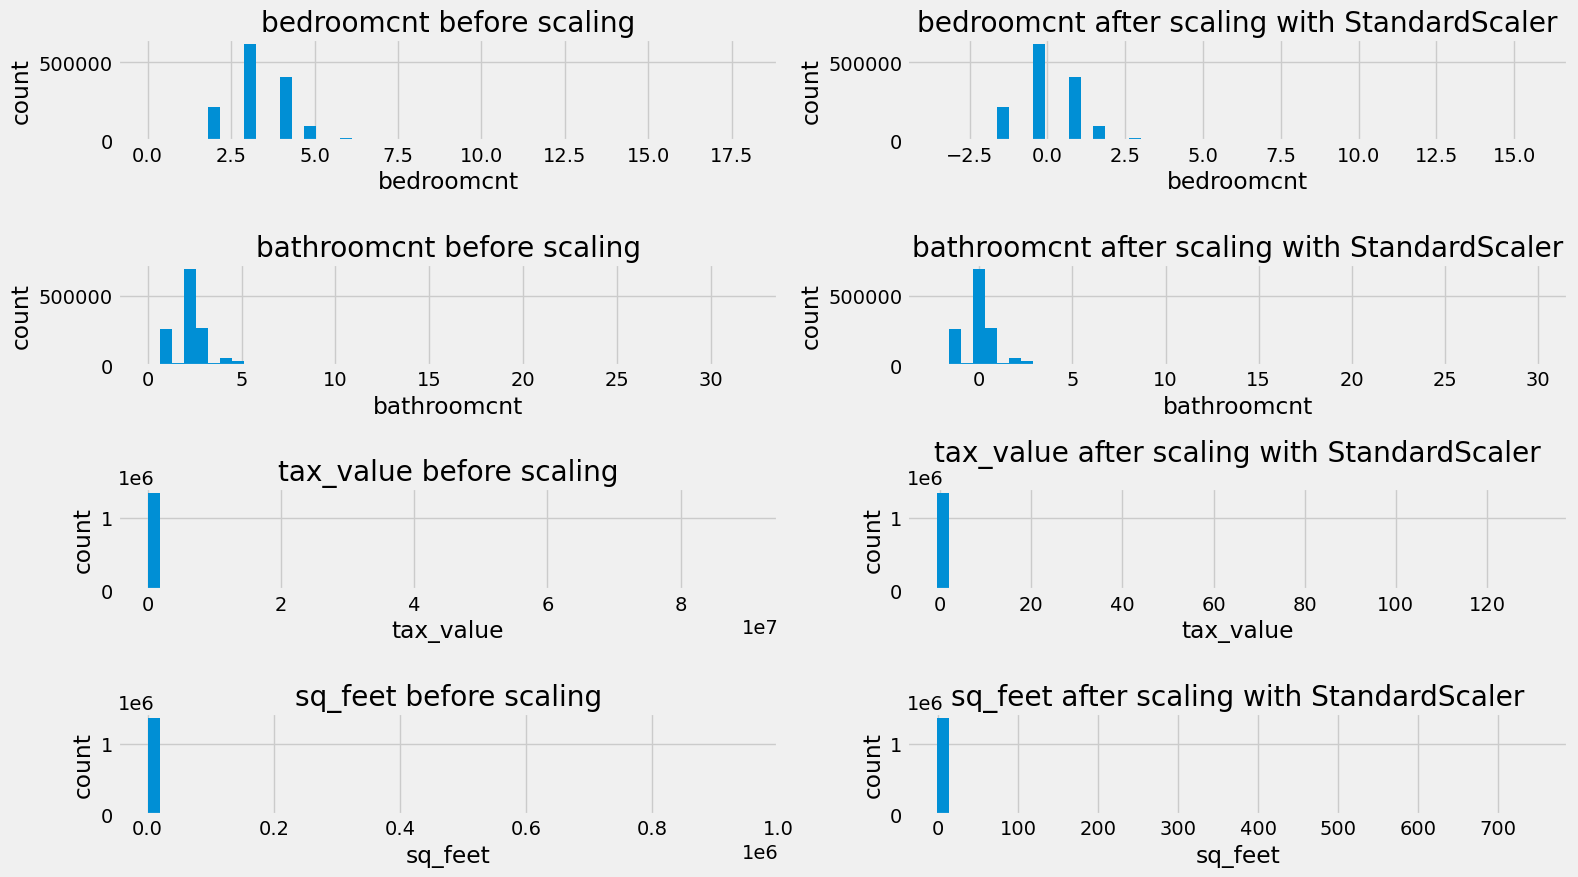

In [35]:
visualize_scaler(scaler=StandardScaler(), df=train, columns_to_scale=columns_to_scale, bins=50)

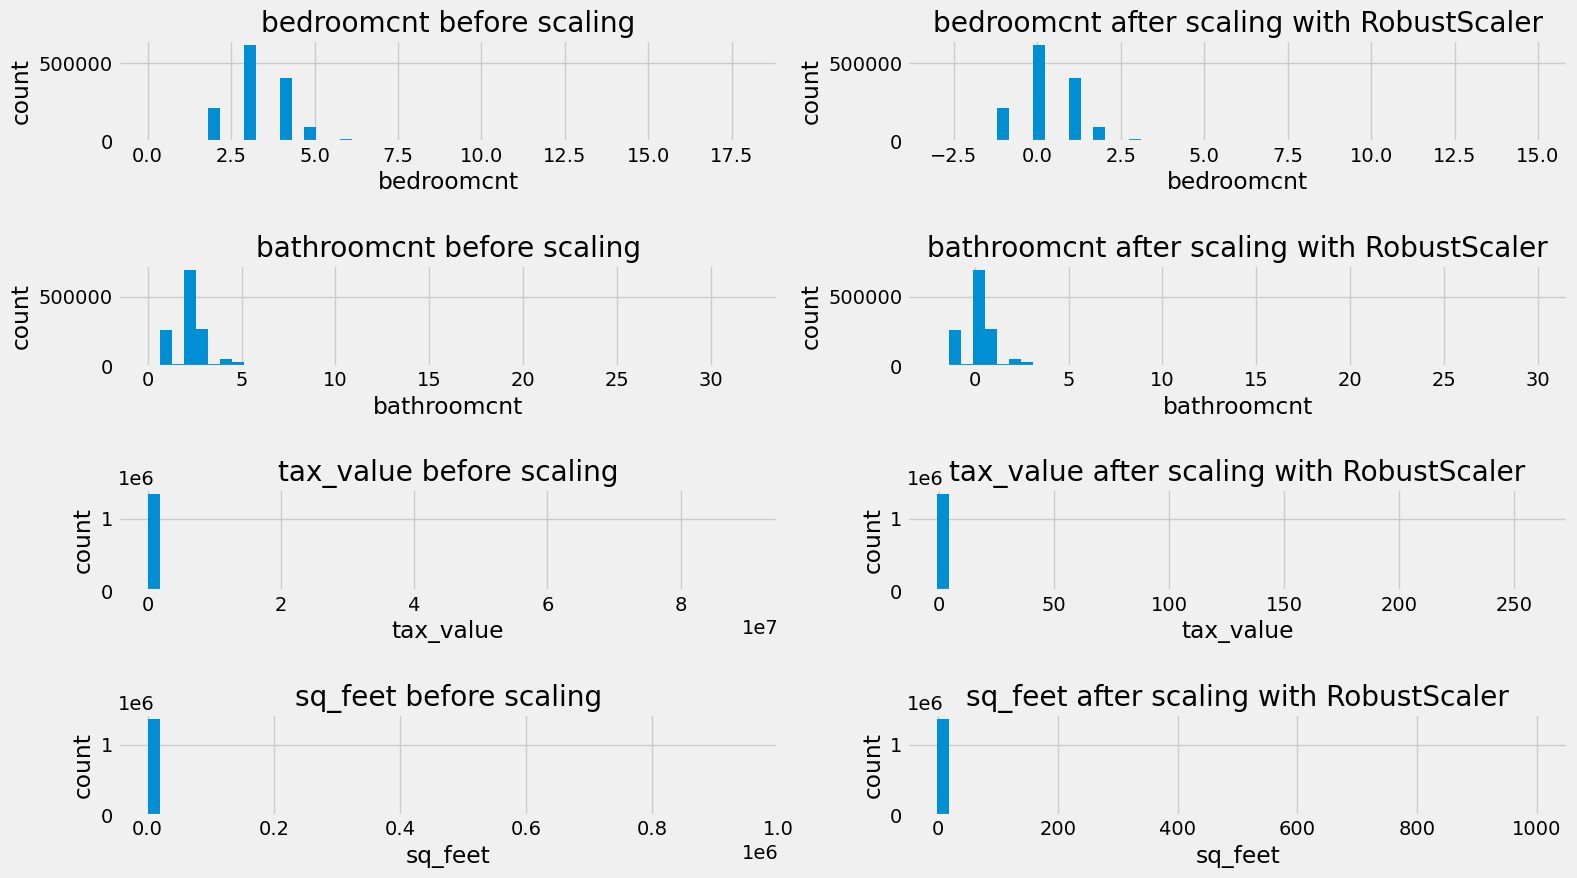

In [36]:
visualize_scaler(scaler=RobustScaler(), df=train, columns_to_scale=columns_to_scale, bins=50)

### 2. Apply the `.inverse_transform` method to your scaled data. Is the resulting dataset the exact same as the original data?

In [38]:
scaler = MinMaxScaler()
original_data = train[['tax_value']]
scaled_data = scaler.fit_transform(original_data)

In [40]:
scaler.inverse_transform(scaled_data)[:5]

array([[520117.],
       [378680.],
       [432768.],
       [393305.],
       [131101.]])

### 3. Read the documentation for sklearn's QuantileTransformer. Use normal for the output_distribution and apply this scaler to your data. Visualize the result of your data scaling.

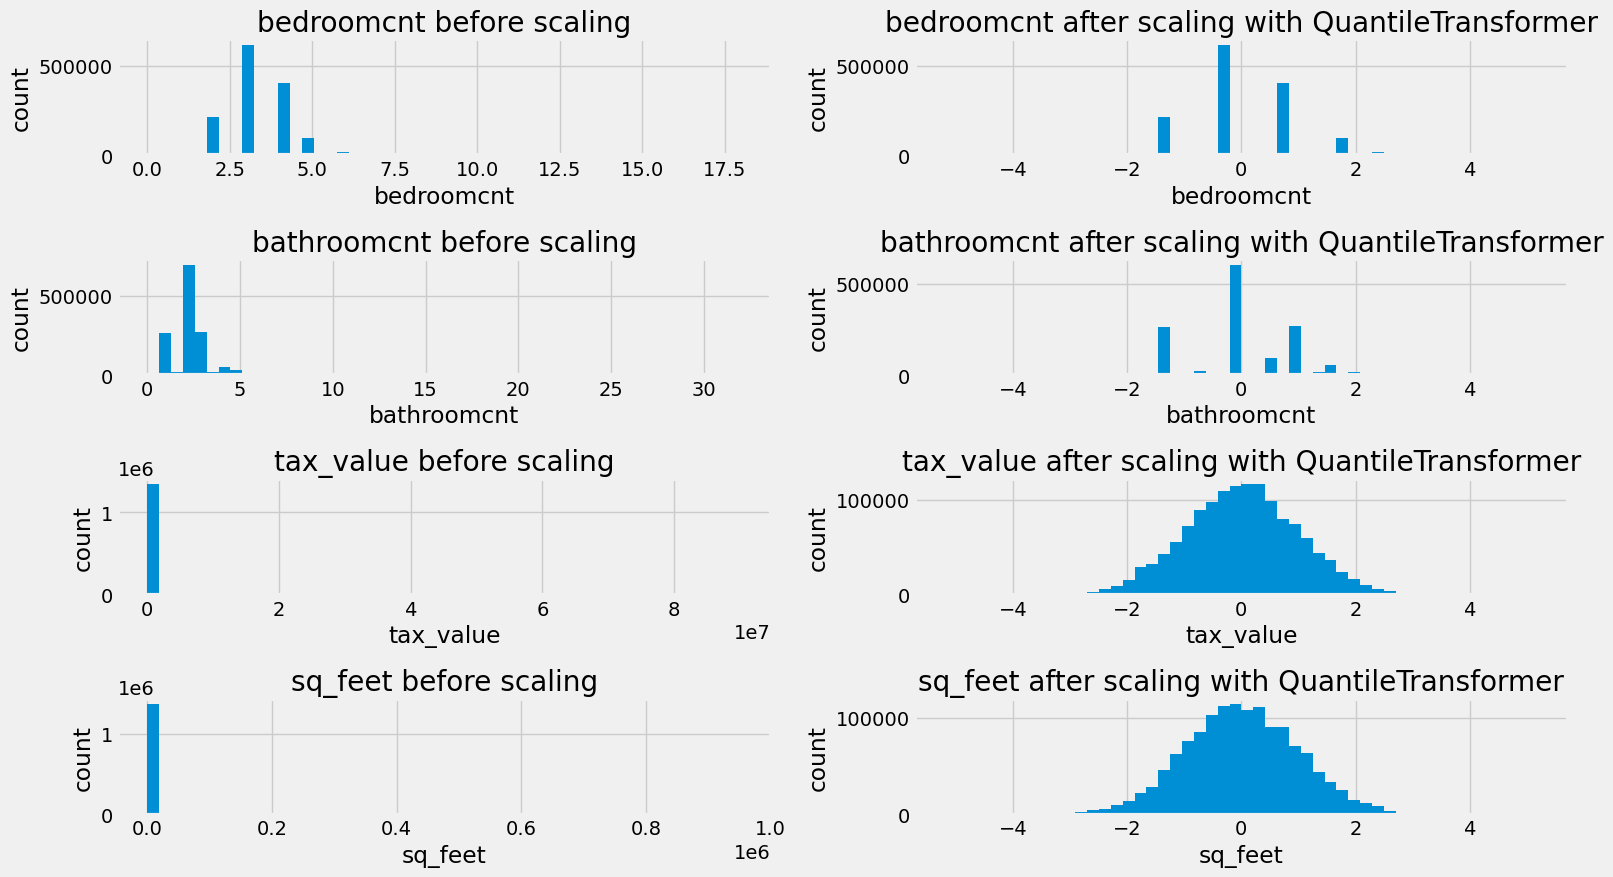

In [41]:
# QuantileTransformer Applied
visualize_scaler(scaler=QuantileTransformer(output_distribution='normal'), 
                 df=train,
                 columns_to_scale=columns_to_scale, 
                 bins=50)

### 4. Use the QuantileTransformer, but omit the output_distribution argument. Visualize your results. What do you notice?

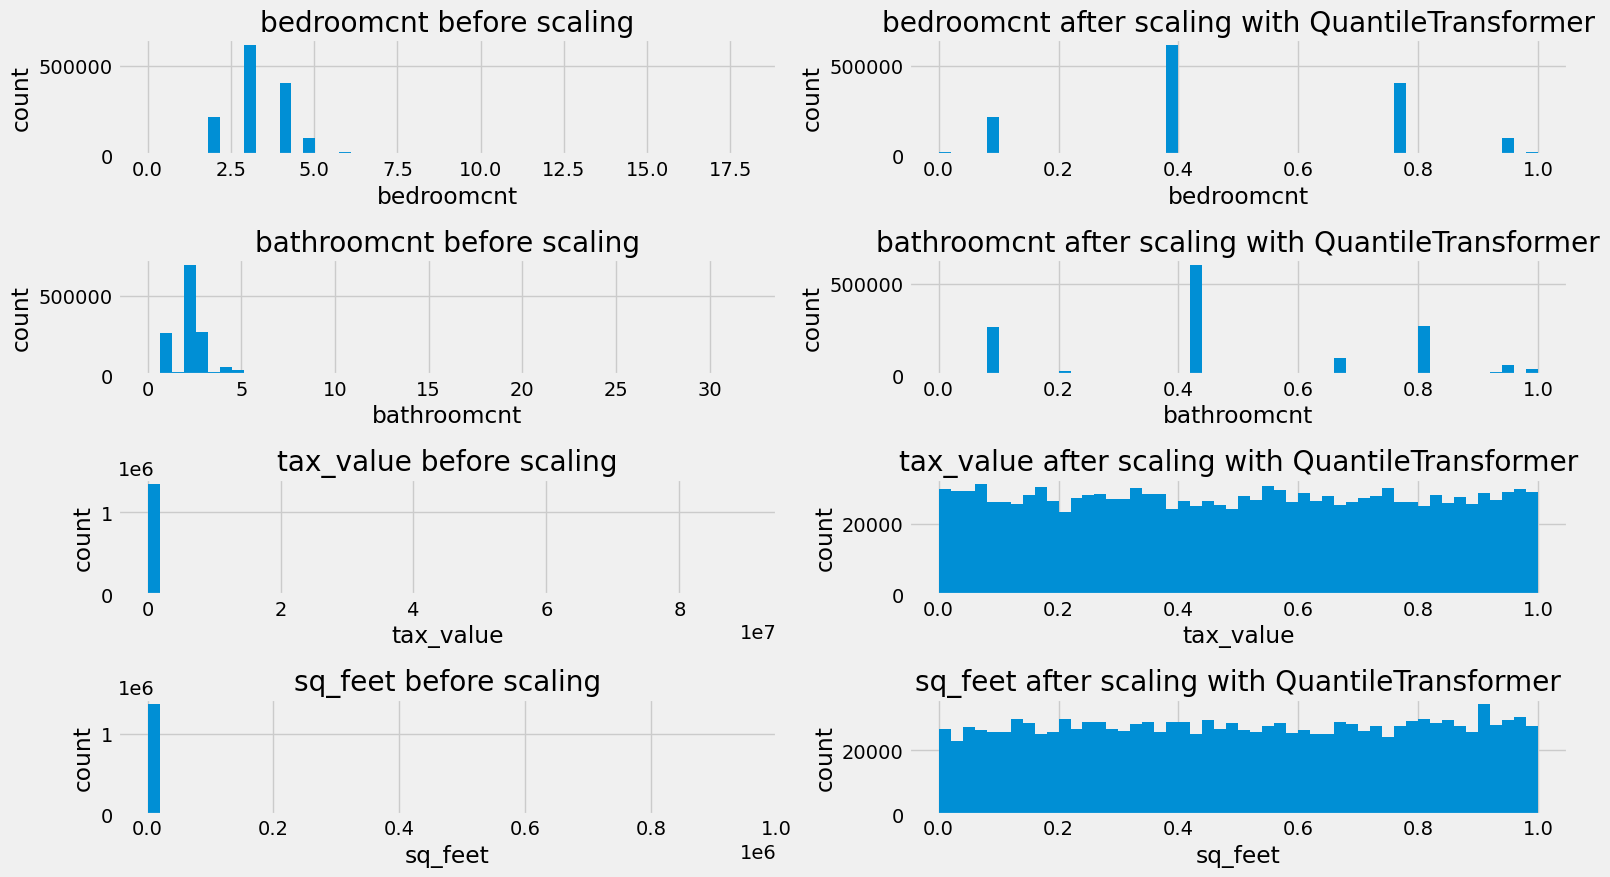

In [42]:
# QuantileTransformer Applied
visualize_scaler(scaler=QuantileTransformer(), 
                 df=train, 
                 columns_to_scale=columns_to_scale, 
                 bins=50)

### 5. Based on the work you've done, choose a scaling method for your dataset. Write a function within your wrangle.py that accepts as input the train, validate, and test data splits, and returns the scaled versions of each. 

In [15]:
# train
x_train_scaled, x_validate_scaled, x_test_scaled = w.QuickScale(x_train, x_validate,x_test)

In [45]:
def scale_data(train, 
               validate, 
               test, 
               columns_to_scale=['bedroomcnt', 'bathroomcnt', 'tax_value', 'sq_feet'],
               return_scaler=False):
    '''
    Scales the 3 data splits. 
    Takes in train, validate, and test data splits and returns their scaled counterparts.
    If return_scalar is True, the scaler object will be returned as well
    '''
    # make copies of our original data so we dont gronk up anything
    train_scaled = train.copy()
    validate_scaled = validate.copy()
    test_scaled = test.copy()
    #     make the thing
    scaler = MinMaxScaler()
    #     fit the thing
    scaler.fit(train[columns_to_scale])
    # applying the scaler:
    train_scaled[columns_to_scale] = pd.DataFrame(scaler.transform(train[columns_to_scale]),
                                                  columns=train[columns_to_scale].columns.values).set_index([train.index.values])
                                                  
    validate_scaled[columns_to_scale] = pd.DataFrame(scaler.transform(validate[columns_to_scale]),
                                                  columns=validate[columns_to_scale].columns.values).set_index([validate.index.values])
    
    test_scaled[columns_to_scale] = pd.DataFrame(scaler.transform(test[columns_to_scale]),
                                                 columns=test[columns_to_scale].columns.values).set_index([test.index.values])
    
    if return_scaler:
        return scaler, train_scaled, validate_scaled, test_scaled
    else:
        return train_scaled, validate_scaled, test_scaled

In [46]:
scaler, train_scaled, validate_scaled, test_scaled = scale_data(train, validate, test, return_scaler=True)

In [47]:
train_scaled

,bedroomcnt,bathroomcnt,sq_feet,tax_value,yearbuilt,county
353297,0.222222,0.06250,0.001924,0.005767,1969,Orange
1185246,0.166667,0.06250,0.001777,0.004199,1949,LA
452922,0.222222,0.09375,0.002408,0.004798,1978,Ventura
163875,0.166667,0.06250,0.002290,0.004361,1969,LA
27042,0.222222,0.06250,0.002295,0.001453,1945,LA
...,...,...,...,...,...,...
1324400,0.277778,0.09375,0.002881,0.008305,1969,Orange
1379871,0.166667,0.06250,0.001870,0.002898,1954,LA
1679286,0.000000,0.03125,0.001301,0.002063,1925,LA
335945,0.222222,0.03125,0.001171,0.000643,1956,LA


In [48]:
validate_scaled

,bedroomcnt,bathroomcnt,sq_feet,tax_value,yearbuilt,county
369370,0.111111,0.031250,0.000998,0.006473,1926,LA
1991416,0.222222,0.125000,0.003148,0.014814,2013,Orange
1287908,0.166667,0.062500,0.001569,0.004546,1956,LA
956626,0.166667,0.078125,0.001442,0.004018,1977,Orange
300590,0.277778,0.093750,0.002747,0.004390,1994,Orange
...,...,...,...,...,...,...
1835398,0.166667,0.062500,0.002784,0.001770,1947,LA
1693221,0.166667,0.031250,0.001227,0.003441,1924,LA
1468261,0.277778,0.093750,0.003413,0.017138,1910,LA
333774,0.222222,0.078125,0.002266,0.008650,1989,Ventura
